# 3D Spectral Image

**Suhas Somnath**

10/12/2018

**This example illustrates how a 3D spectral image would be represented in the Universal Spectroscopy and
Imaging Data (USID) schema and stored in a Hierarchical Data Format (HDF5) file, also referred to as the h5USID file.**

This document is intended as a supplement to the explanation about the `USID data model <../usid_model.html>`_

Please consider downloading this document as a Jupyter notebook using the button at the bottom of this document.

Prerequisites:
--------------
We recommend that you read about the `USID data model <../usid_model.html>`_

We will be making use of the ``pyUSID`` package at multiple places to illustrate the central point. While it is
recommended / a bonus, it is not absolutely necessary that the reader understands how the specific ``pyUSID`` functions
work or why they were used in order to understand the data representation itself.
Examples about these functions can be found in other documentation on pyUSID and the reader is encouraged to read the
supplementary documents.

### Import all necessary packages
The main packages necessary for this example are ``h5py``, ``matplotlib``, and ``sidpy``, in addition to ``pyUSID``:

In [ ]:
import subprocess
import sys
import os
import matplotlib.pyplot as plt
from warnings import warn
import h5py

%matplotlib notebook

def install(package):
    subprocess.call([sys.executable, "-m", "pip", "install", package])


try:
    # This package is not part of anaconda and may need to be installed.
    import wget
except ImportError:
    warn('wget not found.  Will install with pip.')
    import pip
    install('wget')
    import wget

# Finally import pyUSID.
try:
    import pyUSID as usid
    import sidpy
except ImportError:
    warn('pyUSID not found.  Will install with pip.')
    import pip
    install('pyUSID')
    import sidpy
    import pyUSID as usid

h5USID File
-----------
For this example, we will be working with a `Band Excitation Piezoresponse Force Microscopy (BE-PFM)` imaging dataset
acquired from advanced atomic force microscopes. In this dataset, a spectra was collected for each position in a two
dimensional grid of spatial locations. Thus, this is a three dimensional dataset that has been flattened to a two
dimensional matrix in accordance with **Universal Spectroscopy and Imaging Data (USID)** model.

As mentioned earlier, this dataset is available on the USID repository and can be accessed directly as well.
Here, we will simply download the file using ``wget``:

## Download from GitHub

Similarly the corresponding h5USID dataset is also available on the USID repository.
Here, we will simply download the file using ``wget``:

In [2]:
h5_path = 'temp.h5'
url = 'https://raw.githubusercontent.com/pycroscopy/USID/master/data/BELine_0004.h5'
if os.path.exists(h5_path):
    os.remove(h5_path)
_ = wget.download(url, h5_path, bar=None)

Look at file contents
---------------------
Lets open the file and look at its contents using
[sidpy.hdf_utils.print_tree()](https://pycroscopy.github.io/sidpy/notebooks/03_hdf5/hdf_utils_read.html#print_tree())


In [3]:
h5_file = h5py.File(h5_path, mode='r')
sidpy.hdf_utils.print_tree(h5_file)

/
├ Measurement_000
  ---------------
  ├ Channel_000
    -----------
    ├ Bin_FFT
    ├ Bin_Frequencies
    ├ Bin_Indices
    ├ Bin_Step
    ├ Bin_Wfm_Type
    ├ Excitation_Waveform
    ├ Noise_Floor
    ├ Position_Indices
    ├ Position_Values
    ├ Raw_Data
    ├ Spatially_Averaged_Plot_Group_000
      ---------------------------------
      ├ Bin_Frequencies
      ├ Mean_Spectrogram
      ├ Spectroscopic_Parameter
      ├ Step_Averaged_Response
    ├ Spectroscopic_Indices
    ├ Spectroscopic_Values
    ├ UDVS
    ├ UDVS_Indices


## Access the ``Main`` Dataset
We can access the first Main dataset by searching for a dataset that matches its given name using the convenient
function - [pyUSID.hdf_utils.find_dataset()](https://pycroscopy.github.io/sidpy/notebooks/03_hdf5/hdf_utils_read.html#find_dataset()).
Knowing that there is only one dataset with the name `USID_Alternate`, this is a safe operation.



In [4]:
h5_main = usid.hdf_utils.get_all_main(h5_file)[-1]
print(h5_main)

<HDF5 dataset "Raw_Data": shape (16384, 119), type "<c8">
located at: 
	/Measurement_000/Channel_000/Raw_Data 
Data contains: 
	Cantilever Vertical Deflection (V) 
Data dimensions and original shape: 
Position Dimensions: 
	X - size: 128 
	Y - size: 128 
Spectroscopic Dimensions: 
	Frequency - size: 119
Data Type:
	complex64


Here, ``h5_main`` is a [USIDataset](../user_guide/usi_dataset.html), which can be thought of as a supercharged
HDF5 Dataset that is not only aware of the contents of the plain ``USID_Alternate`` dataset but also its links to the
[Ancillary Datasets](https://pycroscopy.github.io/USID/usid_model.html#ancillary-datasets) that make it a ``Main Dataset``.

Understanding Dimensionality
----------------------------
What is more is that the above print statement shows that this ``Main`` Dataset has two ``Position Dimensions`` -
``X`` and ``Y`` each of size ``128`` and at each of these locations, data was recorded as a function of ``119``
values of the single ``Spectroscopic Dimension`` - ``Frequency``.
Therefore, this dataset is a 3D dataset with two position dimensions and one spectroscopic dimension.
To verify this, we can easily get the N-dimensional form of this dataset by invoking the
[get_n_dim_form()](h../user_guide/usi_dataset.html#Reshaping-to-N-dimensions)`_ of the
``USIDataset`` object:



In [5]:
print(h5_main.get_n_dim_form().shape)
print(h5_main.n_dim_labels)

(128, 128, 119)
['X', 'Y', 'Frequency']


## Understanding shapes and flattening

The print statement above shows that the original data is of shape ``(128, 128, 119)``. Let's see if we can arrive at
the shape of the ``Main`` dataset in USID representation.
Recall that USID requires all position dimensions to be flattened along the first axis and all spectroscopic
dimensions to be flattened along the second axis of the ``Main Dataset``. In other words, the data collected at each
location can be laid out along the horizontal direction as is since this dataset only has a single spectroscopic
dimension - ``Frequency``. The ``X`` and ``Y`` position dimensions however need to be collapsed along the vertical
axis of the ``Main`` dataset such that the positions are arranged column-by-column and then row-by-row (assuming that
the columns are the faster varying dimension).

### Visualize the ``Main`` Dataset
Now lets visualize the contents within this ``Main Dataset`` using the ``USIDataset's`` built-in
[visualize()](../user_guide/usi_dataset.html#Interactive-Visualization) function.

Note that the visualization below is static. However, if this document were downloaded as a jupyter notebook, you
would be able to interactively visualize this dataset.



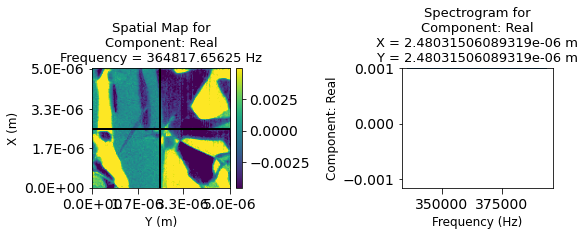

In [6]:
usid.plot_utils.use_nice_plot_params()
h5_main.visualize()

Here is a visualization of the spectra at evenly spaced positions:



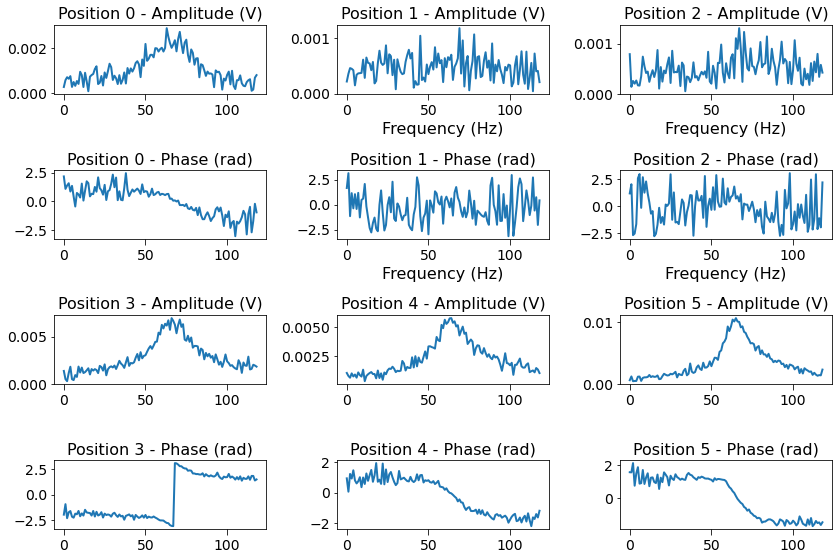

In [7]:
fig, axes = sidpy.plot_utils.plot_complex_spectra(h5_main[()], num_comps=6, amp_units='V',
                                                 subtitle_prefix='Position', evenly_spaced=True,
                                                 x_label=h5_main.spec_dim_descriptors[0])

Alternatively, the spectral image dataset can be visualized via slices across the spectroscopic axis as:



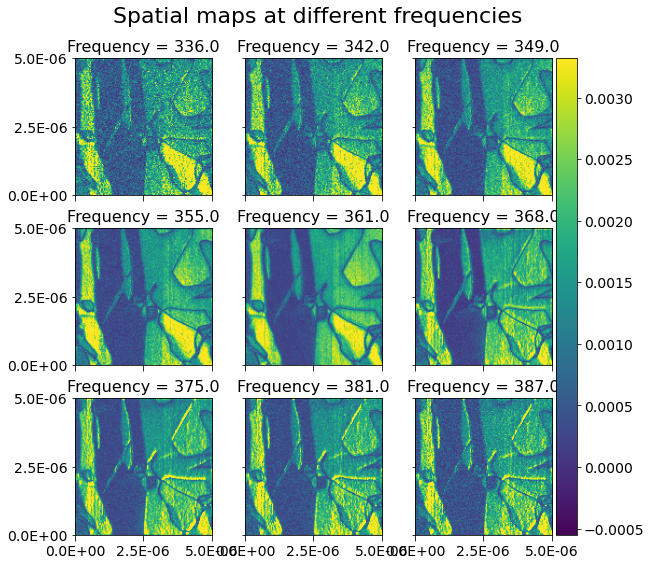

In [8]:
fig, axes = sidpy.plot_utils.plot_map_stack(np.abs(h5_main.get_n_dim_form()), reverse_dims=True, pad_mult=(0.15, 0.15),
                                           title='Spatial maps at different frequencies', stdevs=2,
                                           color_bar_mode='single', num_ticks=3,
                                           x_vec=h5_main.get_pos_values('X'), y_vec=h5_main.get_pos_values('Y'),
                                           evenly_spaced=True, fig_mult=(3, 3), title_yoffset=0.95)
freq_vals = h5_main.get_spec_values(h5_main.spec_dim_labels[0]) *1E-3
for axis, freq_ind in zip(axes, np.linspace(0, h5_main.spec_dim_sizes[0], 9, endpoint=False, dtype=np.uint)):
    axis.set_title('{} = {}'.format(h5_main.spec_dim_labels[0], np.rint(freq_vals[freq_ind])))

Ancillary Datasets
------------------
As mentioned in the documentation on USID, ``Ancillary Datasets`` are required to complete the information for any
dataset. Specifically, these datasets need to provide information about the values against which measurements were
acquired, in addition to explaining the original dimensionality (2 in this case) of the original dataset. Let's look
at the ancillary datasets and see what sort of information they provide. We can access the ``Ancillary Datasets``
linked to the ``Main Dataset`` (``h5_main``) just like a property of the object.

Ancillary Position Datasets
---------------------------



In [ ]:
print('Position Indices:')
print('-------------------------')
print(h5_main.h5_pos_inds)
print('\nPosition Values:')
print('-------------------------')
print(h5_main.h5_pos_vals)

Recall from the USID definition that the shape of the Position Ancillary datasets is ``(N, P)`` where ``N`` is the
number of Position dimensions and the ``P`` is the number of locations over which data was recorded. Here, we have
two position dimensions. Therefore ``N`` is ``2``. ``P`` matches with the first axis of the shape of ``h5_main``
which is ``16384``. Generally, there is no need to remember these rules or construct these ancillary datasets
manually since pyUSID has several functions that automatically simplify this process.

### Visualize the contents of the Position Ancillary Datasets
Notice below that there are two sets of lines, one for each dimension. The blue lines on the left-hand column
appear solid simply because this dimension (``X`` or columns) varies much faster than the other dimension (``Y`` or
rows). The first few rows of the dataset are visualized on the right-hand column.



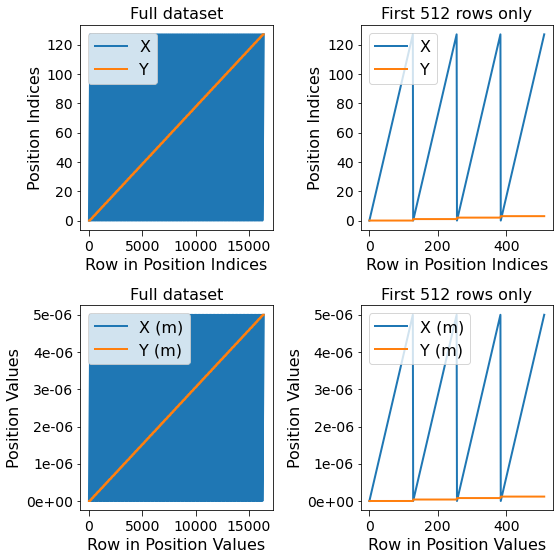

In [9]:
fig, all_axes = plt.subplots(ncols=2, nrows=2, figsize=(8, 8))

for axes, h5_pos_dset, dset_name in zip(all_axes,
                                        [h5_main.h5_pos_inds, h5_main.h5_pos_vals],
                                        ['Position Indices', 'Position Values']):
    axes[0].plot(h5_pos_dset[()])
    axes[0].set_title('Full dataset')
    axes[1].set_title('First 512 rows only')
    axes[1].plot(h5_pos_dset[:512])
    for axis in axes.flat:
        axis.set_xlabel('Row in ' + dset_name)
        axis.set_ylabel(dset_name)
        axis.legend(h5_main.pos_dim_labels)

for axis in all_axes[1]:
    usid.plot_utils.use_scientific_ticks(axis, is_x=False, formatting='%1.e')
    axis.legend(h5_main.pos_dim_descriptors)

fig.tight_layout()

### Making sense of the visualization
Given that the columns vary faster
than the rows means that the contents of each row of the image have been stored end-to-end in the ``Main Dataset``
as opposed to on top of each other as in the original 3D dataset.

### Attributes associated with the Position Indices Dataset
Just looking at the shape and values of the Position ancillary datasets does not provide all the information.
Recall that the ancillary datasets need to have some mandatory attributes like ``labels`` and ``units`` that
describe the quantity and units for each of the dimensions:



In [11]:
for key, val in sidpy.hdf_utils.get_attributes(h5_main.h5_pos_inds).items():
    print('{} : {}'.format(key, val))

X : <HDF5 region reference>
Y : <HDF5 region reference>
labels : ['X' 'Y']
units : ['m' 'm']


Ancillary Spectroscopic Datasets
--------------------------------
Recall that the spectrum at each location was acquired as a function of ``119`` values of the single Spectroscopic
dimension - ``Frequency``. Therefore, according to USID, we should expect the Spectroscopic Dataset to be of shape
``(M, S)`` where M is the number of spectroscopic dimensions (``1`` in this case) and S is the total number of
spectroscopic values against which data was acquired at each location (``119`` in this case).



In [12]:
print('Spectroscopic Indices:')
print('-------------------------')
print(h5_main.h5_spec_inds)
print('\nSpectroscopic Values:')
print('-------------------------')
print(h5_main.h5_spec_vals)

Spectroscopic Indices:
-------------------------
<HDF5 dataset "Spectroscopic_Indices": shape (1, 119), type "<i4">

Spectroscopic Values:
-------------------------
<HDF5 dataset "Spectroscopic_Values": shape (1, 119), type "<f4">


### Visualize the contents of the Spectroscopic Datasets
Observe the single curve that is associated with the single spectroscopic variable ``Frequency``. Also note that the contents
of the ``Spectroscopic Indices`` dataset are just a linearly increasing set of numbers starting from ``0`` according
to the definition of the ``Indices`` datasets which just count the nth value of independent variable that was varied.



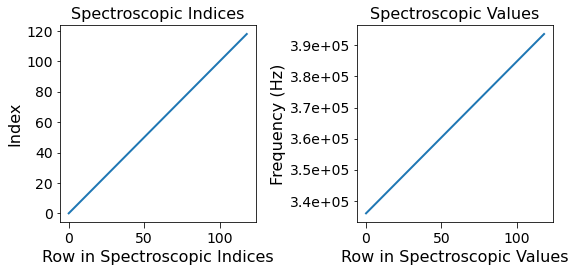

In [14]:
fig, axes = plt.subplots(ncols=2, figsize=(8, 4))
for axis, data, title, y_lab in zip(axes.flat,
                                    [h5_main.h5_spec_inds[()].T, h5_main.h5_spec_vals[()].T],
                                    ['Spectroscopic Indices', 'Spectroscopic Values'],
                                    ['Index', h5_main.spec_dim_descriptors[0]]):
    axis.plot(data)
    axis.set_title(title)
    axis.set_xlabel('Row in ' + title)
    axis.set_ylabel(y_lab)

sidpy.plot_utils.use_scientific_ticks(axis, is_x=False, formatting='%.1e')
# fig.suptitle('Ancillary Spectroscopic Datasets', y=1.05)
fig.tight_layout()

### Attributes within the Spectroscopic Indices Dataset
Again, the attributes of Spectroscopic Datasets show mandatory information about the Spectroscopic dimensions such as
the quantity (``labels``) and ``units``:



In [15]:
for key, val in sidpy.hdf_utils.get_attributes(h5_main.h5_spec_inds).items():
    print('{} : {}'.format(key, val))

Frequency : <HDF5 region reference>
be_line_Plot_Group : <HDF5 region reference>
labels : ['Frequency']
units : ['Hz']


Clean up
--------
Finally lets close the HDF5 file.



In [ ]:
h5_file.close()

Here, we will even delete the HDF5 file. Please comment out the line  below if you want to look at the HDF5 file using
software like HDFView.



In [ ]:
os.remove(h5_path)